In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio

%load_ext autoreload
%autoreload 2

# path to "raw" dataset folder
BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla"

# Visium data

In [3]:
dataset_name = "V1_Adult_Mouse_Brain"
dataset_folder = os.path.join(
    BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla"
)

adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

The spatial coordinates are stored in `adata.obsm["spatial"]`

The tissue images (both hires and lowres png) as well as various scaling factors and metadata are stored in `adata.uns["spatial"]["dataset_name"]`

## Visualize data
Scanpy already provides minimal functionalities to visualize the Visium data with `sc.pl.spatial`.

/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical
... storing 'genome' as categorical


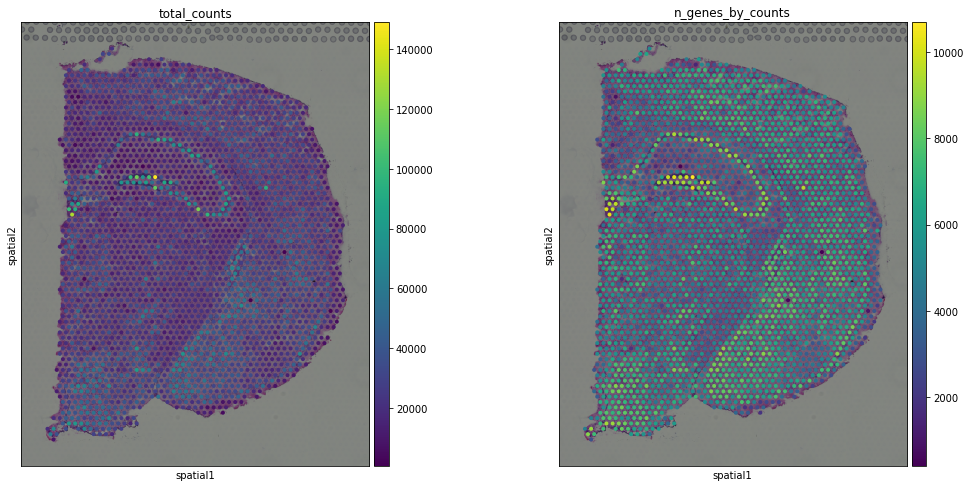

In [7]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

# Feature functions

Put that cell in some feature utils .py

In [77]:
from skimage.feature import greycoprops
from skimage.feature import greycomatrix

def summary_stats(img,quantiles=[0.9,0.5,0.1],mean=False,std=False,channels=[0,1,2]):
    """Calculate summary statistics of color channels
    
    Arguments
    ---------
    img: np.array 
        rgb image in uint8 format.
    qunatiles: list of floats
        Quantiles that are computed
    mean: bool
        Compute mean
    std: bool
        Compute std
    channels: list of ints
        define for which channels histograms are computed
        
    Returns
    -------
    dict of feature values
    
    """
    stats = {}
    for c in channels:
        for q in quantiles:
            stats[f'quantile_{q}_ch_{c}'] = np.quantile(img[:,:,c], q)
        if mean:
            stats[f'mean_ch_{c}'] = np.mean(img[:,:,c], q)
        if std:
            stats[f'std_ch_{c}'] = np.std(img[:,:,c], q)
    return stats

def color_hist(img,bins=10,channels=[0,1,2],v_range=(0,255)):
    """Compute histogram counts of color channel values 
    
    Arguments
    ---------
    img: np.array 
        rgb image in uint8 format.
    bins: int
        number of binned value intervals
    channels: list of ints
        define for which channels histograms are computed
    v_range: tuple of two ints
        Range on which values are binned.
        
    Returns
    -------
    dict of feature values
    
    """
    features = {}
    for c in channels:
        hist = np.histogram(img[:,:,c], bins=10, range=[0,255], weights=None, density=False)
        for i,count in enumerate(hist[0]):
            features[f'ch_{c}_bin_{i}'] = count
    return features
    
    
def grey_texture_features(img, props=['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM'], distances=[1],angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """Calculate texture features
    
    A grey level co-occurence matrix (GLCM) is computed for different combinations of distance and angle. 
    The distance defines the pixel difference of co occurence. The angle define the direction along which 
    we check for co-occurence. The GLCM includes the number of times that grey-level j occurs at a distance 
    d and at an angle theta from grey-level i.
    From a given GLCM texture features are infered.
    
    Arguments
    ---------
    img: np.array 
        rgb image in uint8 format.
    props: list of strs
        texture features that are calculated. See `prop` in skimage.feature.greycoprops
    distances: list of ints
        See `distances` in skimage.feature.greycomatrix 
    angles: list of floats
        See `angles` in skimage.feature.greycomatrix 
        
    Returns
    -------
    dict of feature values
    
    """
    features = {}    
    # get grey scale image
    multiplier = [0.299, 0.587, 0.114]
    grey_img = np.dot(img, multiplier).astype(np.uint8)
    
    comatrix = greycomatrix(grey_img, distances=distances, angles=angles, levels=256)
    for p in props:
        tmp_features = greycoprops(comatrix, prop=p)
        for d_idx, d in enumerate(distances):
            for a_idx, a in enumerate(angles):
                features[f'{p}_dist_{d}_angle_{a:.2f}'] = tmp_features[d_idx,a_idx]
    return features
    


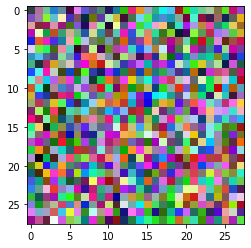

In [60]:
tst = np.random.randint(256, size=(28, 28, 3))
plt.imshow(tst)

In [78]:
print("SUMMARY STATS",summary_stats(tst))
print("COLOR HISTOGRAM", color_hist(tst))
print("TEXTURE FEATURES",grey_texture_features(tst))

SUMMARY STATS {'quantile_0.9_ch_0': 231.0, 'quantile_0.5_ch_0': 128.0, 'quantile_0.1_ch_0': 23.600000000000023, 'quantile_0.9_ch_1': 227.0, 'quantile_0.5_ch_1': 126.0, 'quantile_0.1_ch_1': 25.0, 'quantile_0.9_ch_2': 232.0, 'quantile_0.5_ch_2': 130.0, 'quantile_0.1_ch_2': 28.0}
COLOR HISTOGRAM {'color_hist_ch_0_bin_0': 83, 'color_hist_ch_0_bin_1': 84, 'color_hist_ch_0_bin_2': 84, 'color_hist_ch_0_bin_3': 69, 'color_hist_ch_0_bin_4': 71, 'color_hist_ch_0_bin_5': 81, 'color_hist_ch_0_bin_6': 71, 'color_hist_ch_0_bin_7': 73, 'color_hist_ch_0_bin_8': 85, 'color_hist_ch_0_bin_9': 83, 'color_hist_ch_1_bin_0': 81, 'color_hist_ch_1_bin_1': 80, 'color_hist_ch_1_bin_2': 79, 'color_hist_ch_1_bin_3': 88, 'color_hist_ch_1_bin_4': 77, 'color_hist_ch_1_bin_5': 84, 'color_hist_ch_1_bin_6': 90, 'color_hist_ch_1_bin_7': 64, 'color_hist_ch_1_bin_8': 72, 'color_hist_ch_1_bin_9': 69, 'color_hist_ch_2_bin_0': 74, 'color_hist_ch_2_bin_1': 80, 'color_hist_ch_2_bin_2': 81, 'color_hist_ch_2_bin_3': 62, 'color_hi